### 4. Time Series Forecasting with LSTMs for daily Coronavirus Cases

关于时间序列的数据分析，常规的经典方法是用ARIMA的方法进行，近几年流行的方法是长短时记忆网络模型（LSTM）
循环递归神经网络在处理时序数据上有非常出色的表现。
这一节使用LSTMs进行未来COVID-19的数据预测

In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

CPython 3.7.6
IPython 7.17.0

numpy 1.18.5
pandas 1.1.0
torch 1.5.1


In [2]:
import torch

import os
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt 
from matplotlib import rc 
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn,optim 

In [3]:
%matplotlib inline
%config InlineBackend.figure_format="retina"

In [4]:
sns.set(style='whitegrid',palette='muted',font_scale=1.2)

In [5]:
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

In [6]:
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

In [7]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
#!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

In [9]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')

In [10]:
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,989,989,989,989,989,989,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,399,399,399,400,400,410,410,411,413,414
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,573,575,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,293,293,293,294,294,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,91,91,91,91


In [11]:
'''
需要对数据进行两项处理，第一项是去掉国家 省份 城市等
这个数据是经过累加的，我们需要撤销这个操作
'''
df = df.iloc[:, 4:]

In [12]:
df

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,1,9,15,39,60,70,106,152,200,237,...,989,989,989,989,989,989,990,990,990,990
1,14,22,36,41,68,80,91,111,114,139,...,399,399,399,400,400,410,410,411,413,414
2,6,9,27,57,75,110,132,147,182,211,...,573,575,576,576,576,576,576,576,576,576
3,1,5,10,18,35,59,80,84,101,120,...,293,293,293,294,294,296,296,296,296,296
4,0,2,2,4,7,14,19,24,26,29,...,91,91,91,91,91,91,91,91,91,91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
139,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [13]:
df.isnull().sum().sum()

0

In [14]:
daily_cases = df.sum(axis=0)

In [15]:
daily_cases

1/22/20      555
1/23/20      653
1/24/20      941
1/25/20     1434
1/26/20     2118
1/27/20     2927
1/28/20     5578
1/29/20     6166
1/30/20     8234
1/31/20     9927
2/1/20     12038
2/2/20     16787
2/3/20     19881
2/4/20     23892
2/5/20     27636
2/6/20     30818
2/7/20     34392
2/8/20     37121
2/9/20     40151
2/10/20    42763
2/11/20    44803
2/12/20    45222
2/13/20    60370
2/14/20    66887
2/15/20    69032
2/16/20    71226
2/17/20    73260
2/18/20    75138
2/19/20    75641
2/20/20    76199
2/21/20    76843
2/22/20    78599
2/23/20    78985
2/24/20    79570
2/25/20    80415
2/26/20    81397
2/27/20    82756
2/28/20    84122
2/29/20    86013
3/1/20     88371
3/2/20     90313
dtype: int64

In [16]:
daily_cases.index = pd.to_datetime(daily_cases.index)

In [17]:
daily_cases

2020-01-22      555
2020-01-23      653
2020-01-24      941
2020-01-25     1434
2020-01-26     2118
2020-01-27     2927
2020-01-28     5578
2020-01-29     6166
2020-01-30     8234
2020-01-31     9927
2020-02-01    12038
2020-02-02    16787
2020-02-03    19881
2020-02-04    23892
2020-02-05    27636
2020-02-06    30818
2020-02-07    34392
2020-02-08    37121
2020-02-09    40151
2020-02-10    42763
2020-02-11    44803
2020-02-12    45222
2020-02-13    60370
2020-02-14    66887
2020-02-15    69032
2020-02-16    71226
2020-02-17    73260
2020-02-18    75138
2020-02-19    75641
2020-02-20    76199
2020-02-21    76843
2020-02-22    78599
2020-02-23    78985
2020-02-24    79570
2020-02-25    80415
2020-02-26    81397
2020-02-27    82756
2020-02-28    84122
2020-02-29    86013
2020-03-01    88371
2020-03-02    90313
dtype: int64

In [18]:
daily_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

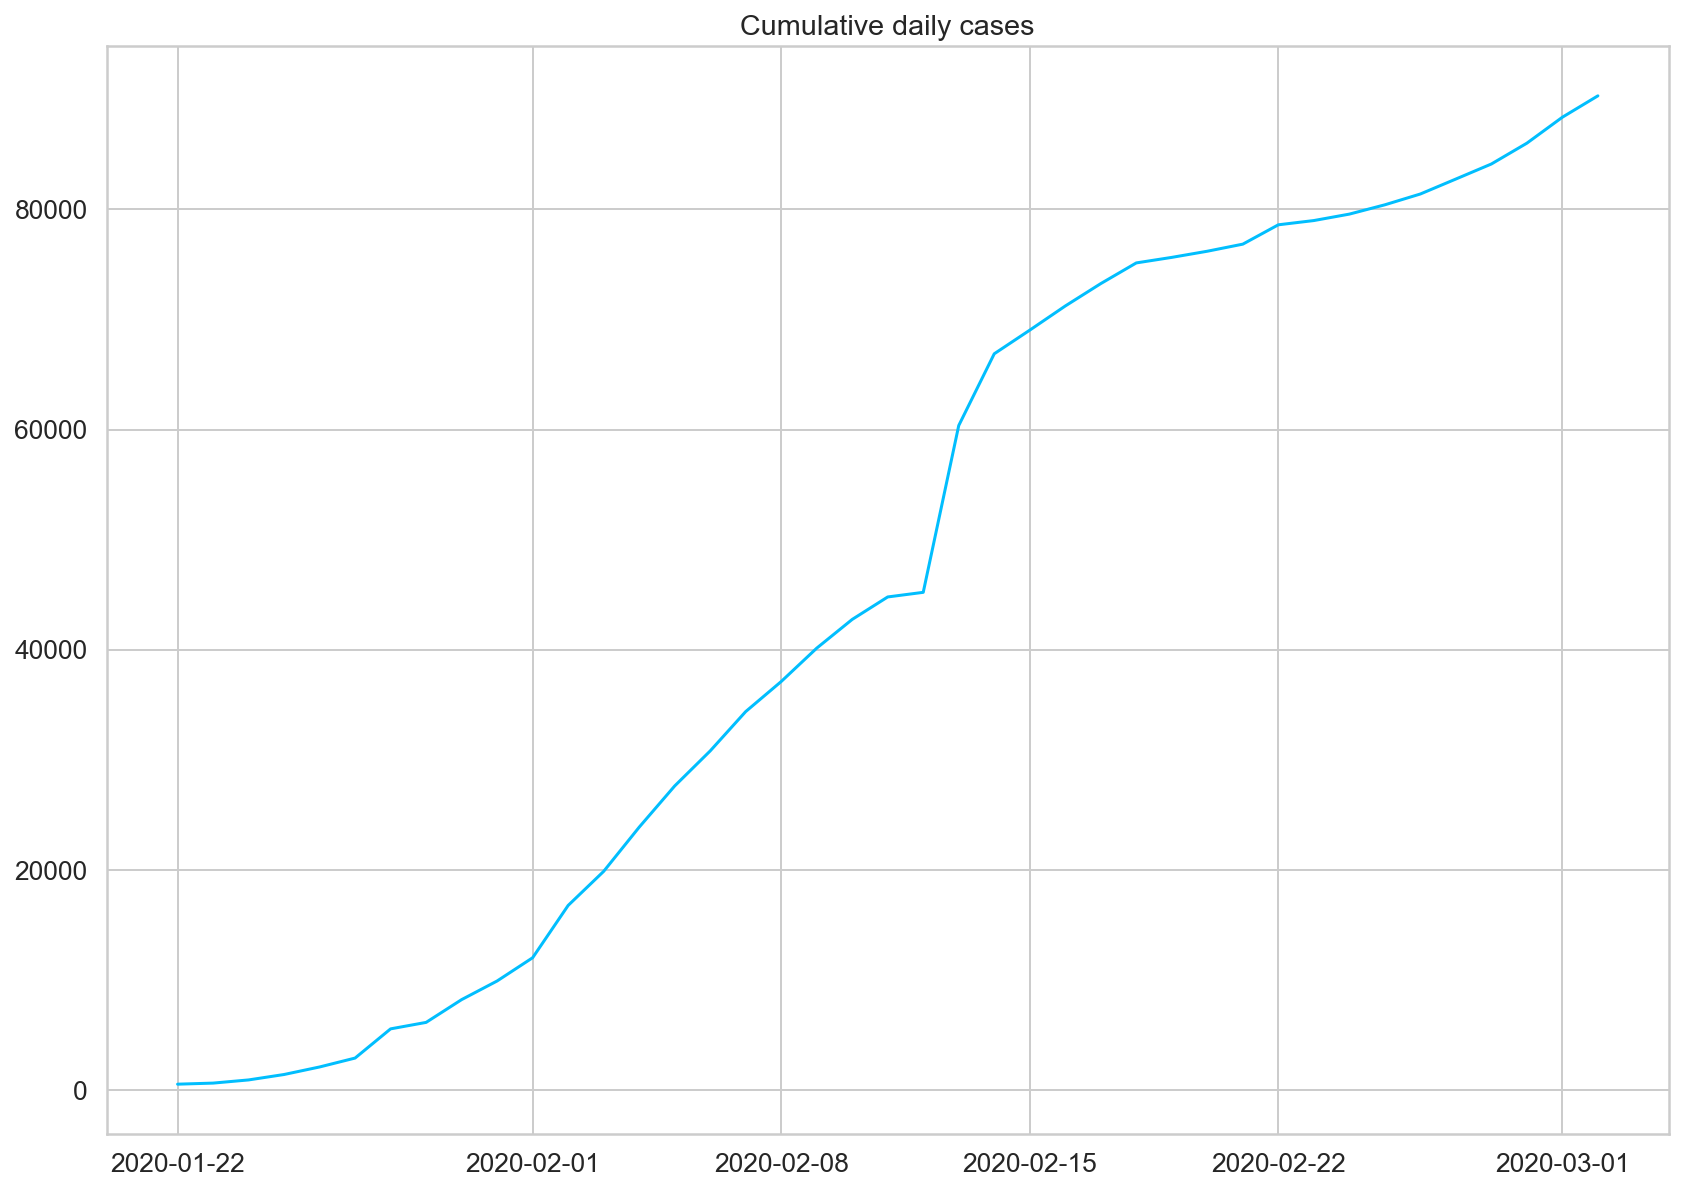

In [19]:
plt.plot(daily_cases)
plt.title("Cumulative daily cases");

In [20]:
'''
下面将累加的过程撤销
'''
daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)

In [21]:
daily_cases.head()

2020-01-22    555
2020-01-23     98
2020-01-24    288
2020-01-25    493
2020-01-26    684
dtype: int64

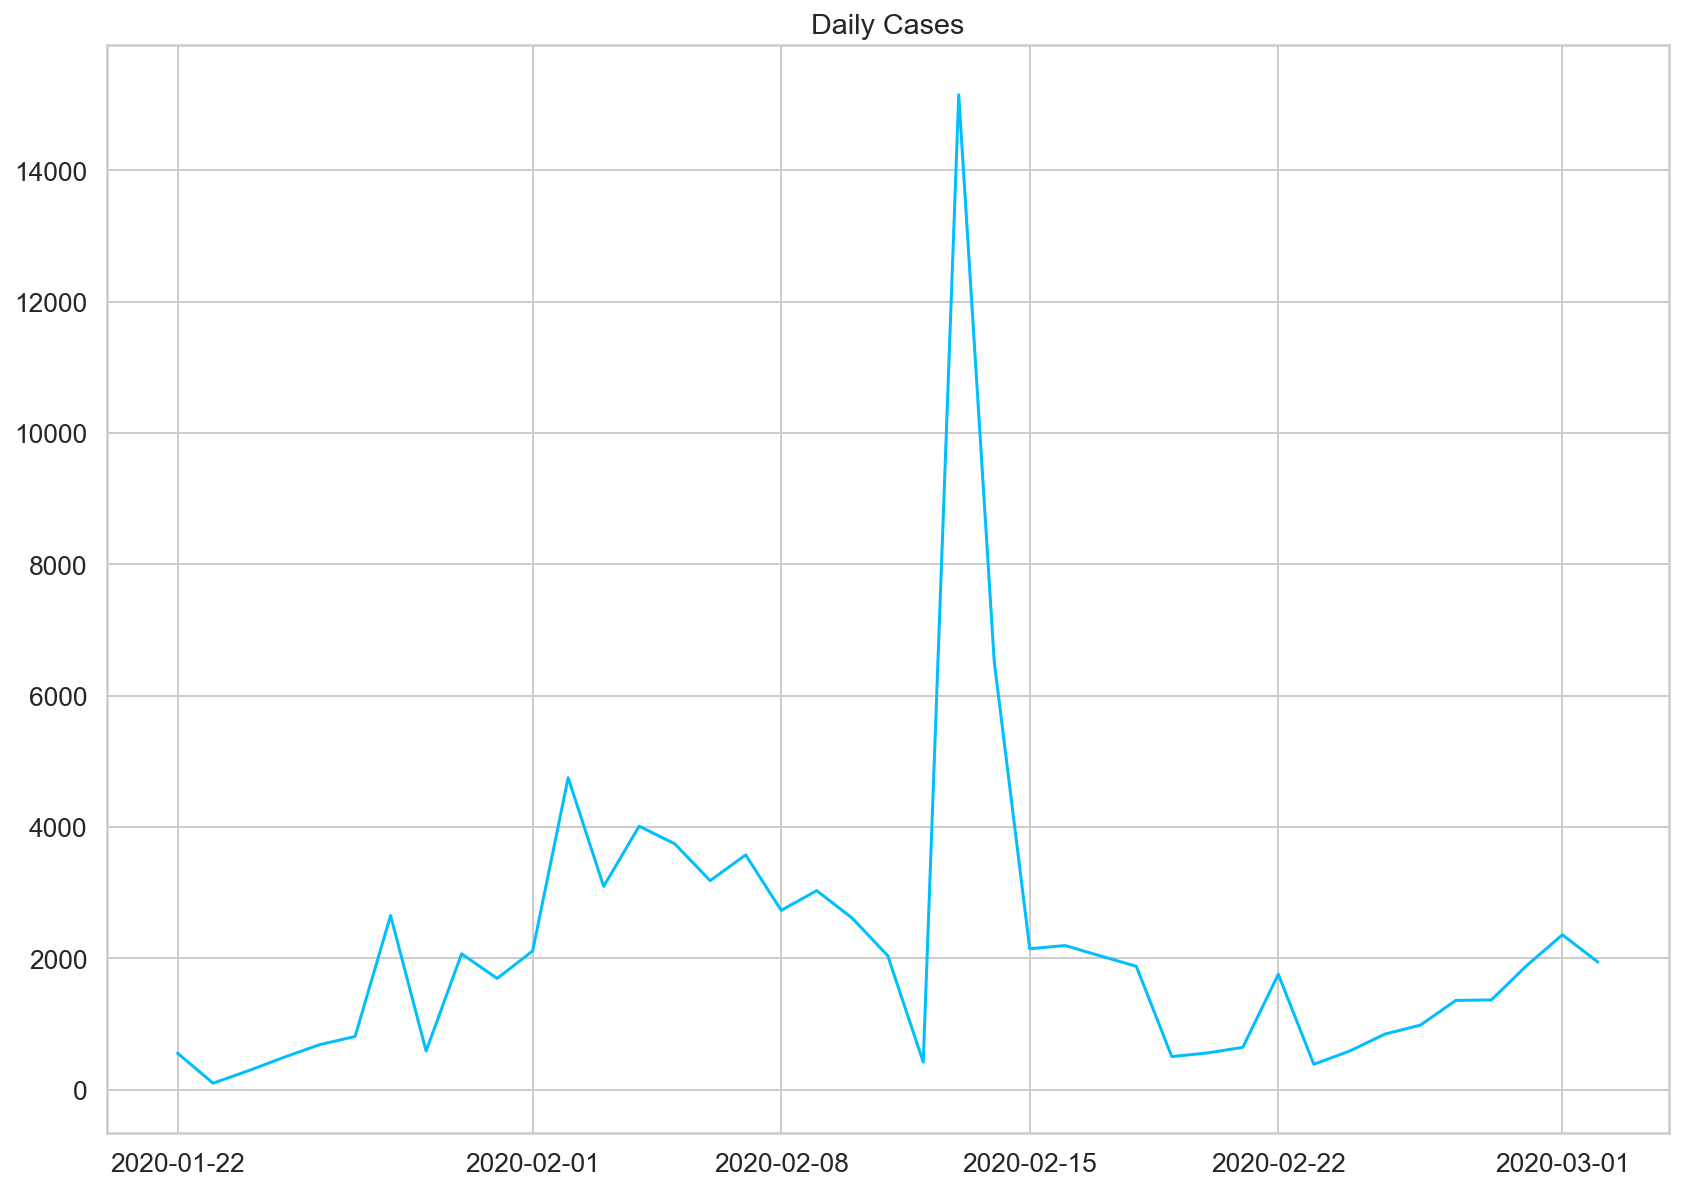

In [22]:
plt.plot(daily_cases)
plt.title("Daily Cases");

In [23]:
'''
首先保留前27天的数据用来进行训练同时使用剩下的进行测试
'''
test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

In [24]:
train_data.shape

(27,)

In [25]:
'''
下面对数据进行归一化处理
'''
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data,axis=1))

train_data = scaler.transform(np.expand_dims(train_data,axis=1))

test_data = scaler.transform(np.expand_dims(test_data,axis=1))

In [26]:
train_data

array([[0.03036545],
       [0.        ],
       [0.01262458],
       [0.02624585],
       [0.03893688],
       [0.04724252],
       [0.16963455],
       [0.03255814],
       [0.13089701],
       [0.10598007],
       [0.13375415],
       [0.30903654],
       [0.19906977],
       [0.26      ],
       [0.24225914],
       [0.20491694],
       [0.23096346],
       [0.17481728],
       [0.19481728],
       [0.16704319],
       [0.12903654],
       [0.0213289 ],
       [1.        ],
       [0.42651163],
       [0.13601329],
       [0.1392691 ],
       [0.12863787]])

In [27]:
'''
下面将数据拆分为小的序列 
'''
def create_sequences(data,seq_length):
    xs = []
    ys = []
    
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    
    return np.array(xs),np.array(ys)

In [28]:
seq_length = 5
X_train,y_train = create_sequences(train_data,seq_length)
X_test,y_test = create_sequences(test_data,seq_length)

In [29]:
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [30]:
X_train

tensor([[[0.0304],
         [0.0000],
         [0.0126],
         [0.0262],
         [0.0389]],

        [[0.0000],
         [0.0126],
         [0.0262],
         [0.0389],
         [0.0472]],

        [[0.0126],
         [0.0262],
         [0.0389],
         [0.0472],
         [0.1696]],

        [[0.0262],
         [0.0389],
         [0.0472],
         [0.1696],
         [0.0326]],

        [[0.0389],
         [0.0472],
         [0.1696],
         [0.0326],
         [0.1309]],

        [[0.0472],
         [0.1696],
         [0.0326],
         [0.1309],
         [0.1060]],

        [[0.1696],
         [0.0326],
         [0.1309],
         [0.1060],
         [0.1338]],

        [[0.0326],
         [0.1309],
         [0.1060],
         [0.1338],
         [0.3090]],

        [[0.1309],
         [0.1060],
         [0.1338],
         [0.3090],
         [0.1991]],

        [[0.1060],
         [0.1338],
         [0.3090],
         [0.1991],
         [0.2600]],

        [[0.1338],
         [0

In [31]:
y_train

tensor([[0.0472],
        [0.1696],
        [0.0326],
        [0.1309],
        [0.1060],
        [0.1338],
        [0.3090],
        [0.1991],
        [0.2600],
        [0.2423],
        [0.2049],
        [0.2310],
        [0.1748],
        [0.1948],
        [0.1670],
        [0.1290],
        [0.0213],
        [1.0000],
        [0.4265],
        [0.1360],
        [0.1393]])

In [32]:
'''
上面的预处理我们看到每一个训练样本数据都是一个5个数据点的序列以及对应一个标签为预测的下一个值
'''
X_train.shape

torch.Size([21, 5, 1])

In [33]:
train_data[:10]

array([[0.03036545],
       [0.        ],
       [0.01262458],
       [0.02624585],
       [0.03893688],
       [0.04724252],
       [0.16963455],
       [0.03255814],
       [0.13089701],
       [0.10598007]])

##### Build a model

In [34]:
class CoronaVirusPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor,self).__init__()
        
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            num_layers = n_layers,
            dropout = 0.5
        )
        
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)
    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(sequences.view(len(sequences), self.seq_len, -1),self.hidden)
        last_time_step = lstm_out.view(self.seq_len,len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

In [35]:
'''
上面定义了一个类 用于初始化所有需要的参数以及创建网络层 
reset_hidden_state函数的作用是使用一个stateless的LSTM，因此我们需要在每一个样本使用之后重置state
forward函数获取sequences然后前向传播一遍网络得到一个预测结果
'''

'\n上面定义了一个类 用于初始化所有需要的参数以及创建网络层 \nreset_hidden_state函数的作用是使用一个stateless的LSTM，因此我们需要在每一个样本使用之后重置state\nforward函数获取sequences然后前向传播一遍网络得到一个预测结果\n'

In [36]:
def train_model(model, train_data,train_labels,test_data=None,test_labels=None):
    loss_fn = torch.nn.MSELoss(reduction='sum')
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    num_epochs = 60
    
    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)
    
    for t in range(num_epochs):
        model.reset_hidden_state()
        
        y_pred = model(train_data)
        
        loss = loss_fn(y_pred.float(),train_labels)
        
        if test_data is not None:
            with torch.no_grad():
                y_test_pred = model(test_data)
                test_loss = loss_fn(y_test_pred.float(), test_labels)
            test_hist[t] = test_loss.item()
            
            if t % 10 == 0:
                print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
        elif t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()}')
        
        train_hist[t] = loss.item()
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
    
    return model.eval(), train_hist, test_hist

In [37]:
X_train

tensor([[[0.0304],
         [0.0000],
         [0.0126],
         [0.0262],
         [0.0389]],

        [[0.0000],
         [0.0126],
         [0.0262],
         [0.0389],
         [0.0472]],

        [[0.0126],
         [0.0262],
         [0.0389],
         [0.0472],
         [0.1696]],

        [[0.0262],
         [0.0389],
         [0.0472],
         [0.1696],
         [0.0326]],

        [[0.0389],
         [0.0472],
         [0.1696],
         [0.0326],
         [0.1309]],

        [[0.0472],
         [0.1696],
         [0.0326],
         [0.1309],
         [0.1060]],

        [[0.1696],
         [0.0326],
         [0.1309],
         [0.1060],
         [0.1338]],

        [[0.0326],
         [0.1309],
         [0.1060],
         [0.1338],
         [0.3090]],

        [[0.1309],
         [0.1060],
         [0.1338],
         [0.3090],
         [0.1991]],

        [[0.1060],
         [0.1338],
         [0.3090],
         [0.1991],
         [0.2600]],

        [[0.1338],
         [0

In [38]:
model = CoronaVirusPredictor(
    n_features=1,
    n_hidden=512,
    seq_len=seq_length,
    n_layers=2
)
model, train_hist, test_hist = train_model(model,X_train,y_train,X_test,y_test)

Epoch 0 train loss: 1.6297188997268677 test loss: 0.041186608374118805
Epoch 10 train loss: 0.8466923832893372 test loss: 0.12416432052850723
Epoch 20 train loss: 0.821993350982666 test loss: 0.1438201367855072
Epoch 30 train loss: 0.8200693130493164 test loss: 0.2190694361925125
Epoch 40 train loss: 0.810839056968689 test loss: 0.1797715127468109
Epoch 50 train loss: 0.7957305312156677 test loss: 0.19855862855911255


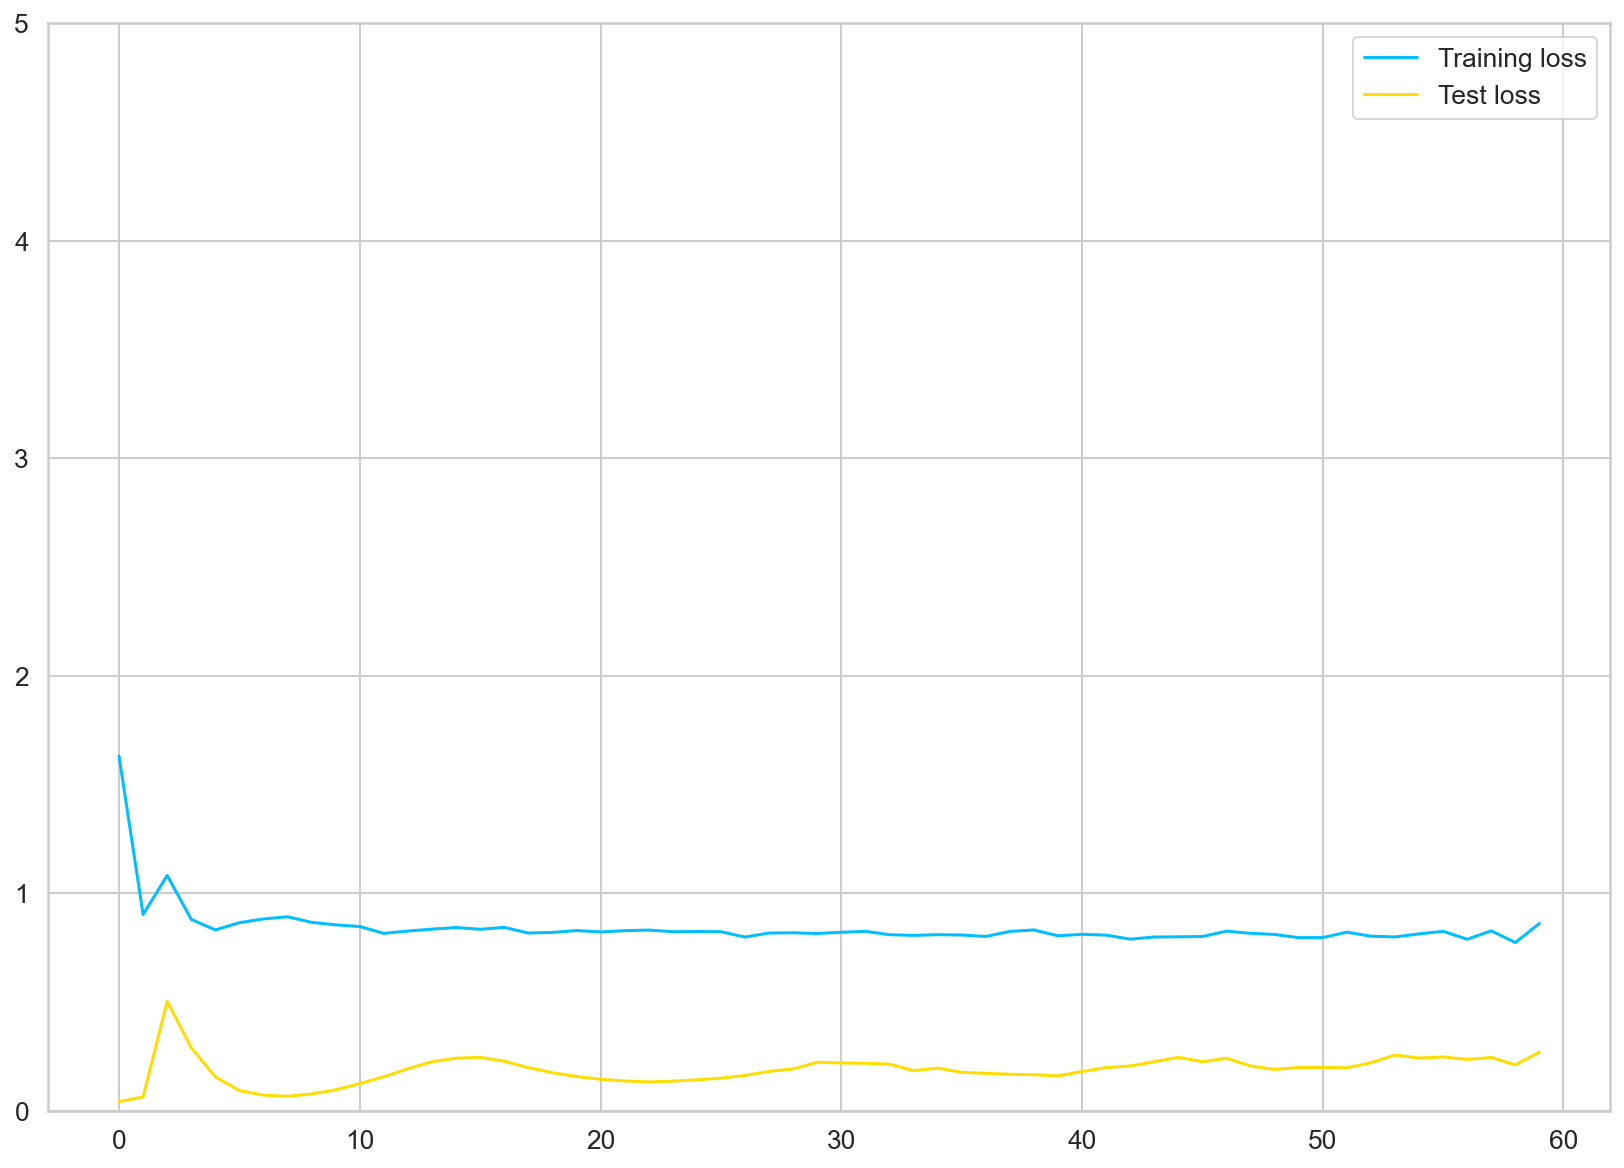

In [39]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.ylim((0,5))
plt.legend();

In [42]:
with torch.no_grad():
    test_seq = X_test[:1]
    preds = []
    for _ in range(len(X_test)):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq,[pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [44]:
true_cases = scaler.inverse_transform(np.expand_dims(y_test.flatten().numpy(), axis=0)).flatten()

predicted_cases = scaler.inverse_transform(np.expand_dims(preds, axis=0)).flatten()

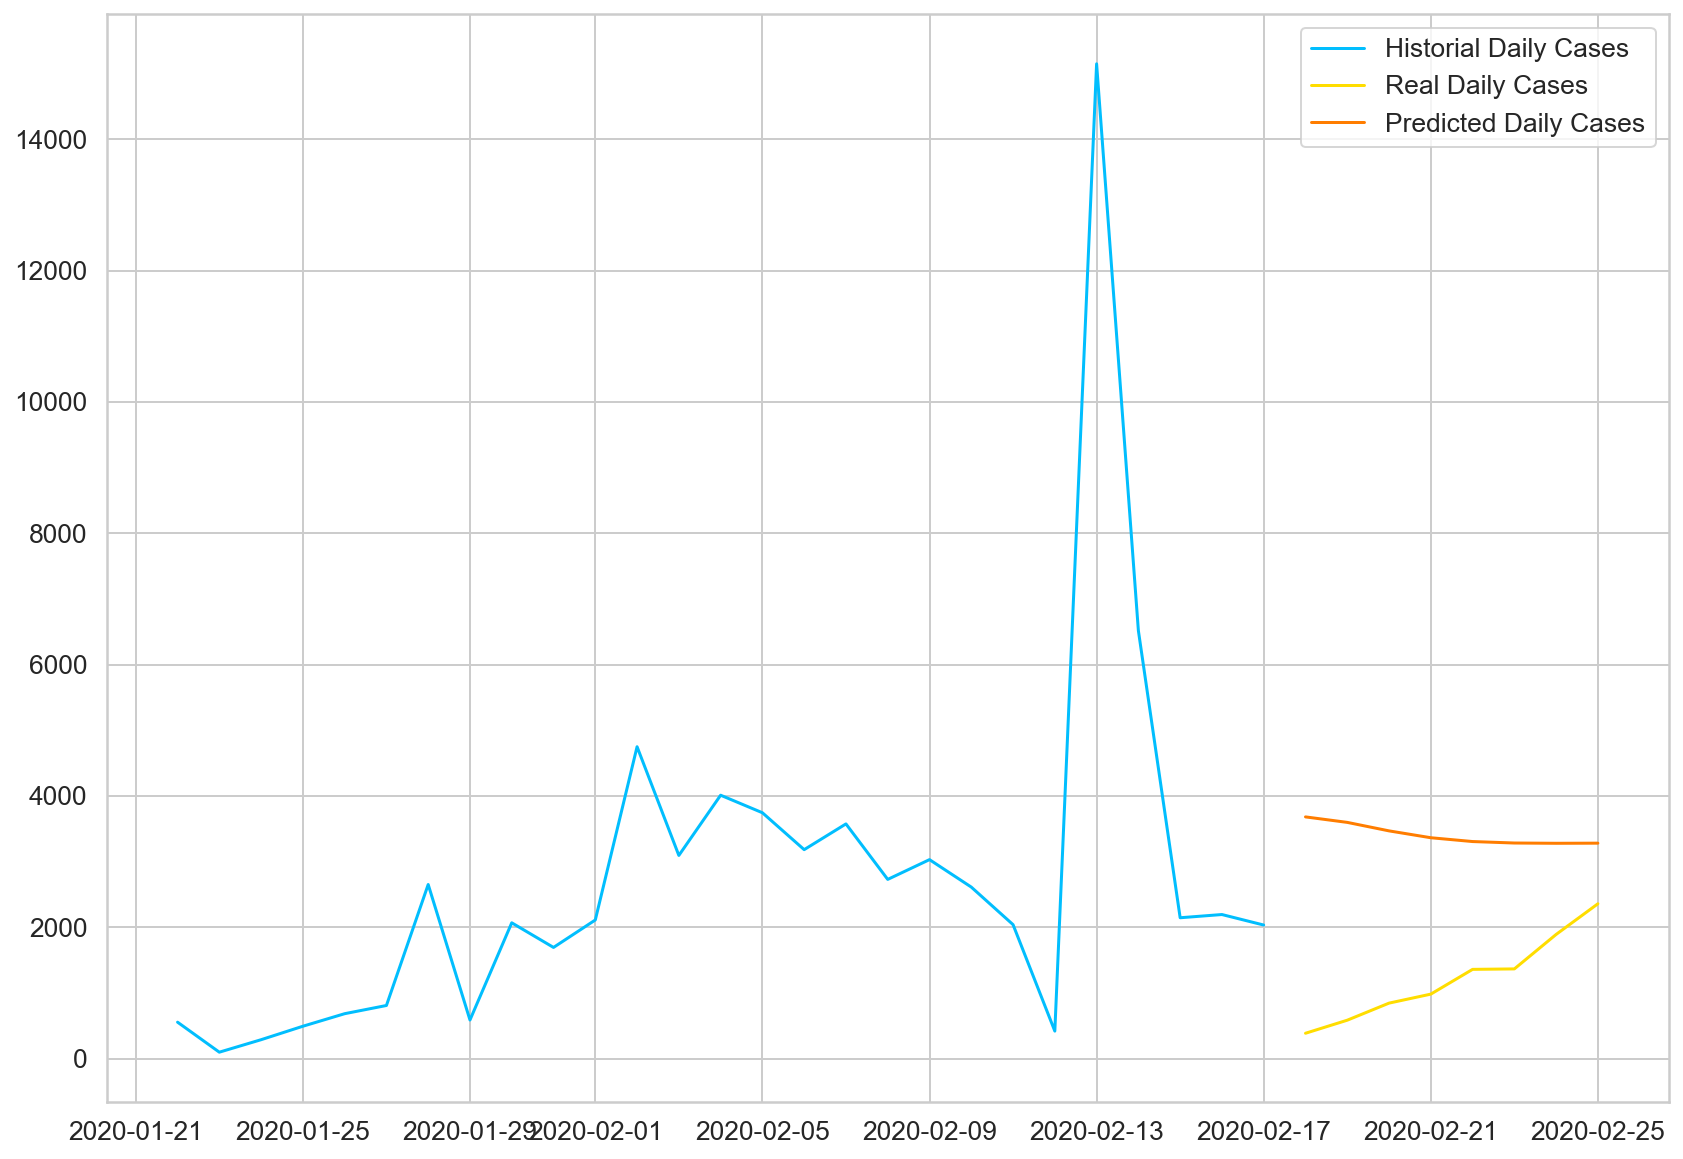

In [45]:
plt.plot(
    daily_cases.index[:len(train_data)],
    scaler.inverse_transform(train_data).flatten(),
    label='Historial Daily Cases'
)

plt.plot(
    daily_cases.index[len(train_data):len(train_data)+len(true_cases)],
    true_cases,
    label='Real Daily Cases'
)

plt.plot(
    daily_cases.index[len(train_data):len(train_data)+len(true_cases)],
    predicted_cases,
    label='Predicted Daily Cases'
)

plt.legend();

由于数据量太少了这个预测的结果不太好。

In [46]:
'''
用所有的数据来训练模型 
'''
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(daily_cases, axis=1))

all_data = scaler.transform(np.expand_dims(daily_cases, axis=1))

all_data.shape

(41, 1)

In [47]:
X_all, y_all = create_sequences(all_data, seq_length)

X_all = torch.from_numpy(X_all).float()
y_all = torch.from_numpy(y_all).float()

model = CoronaVirusPredictor(
    n_features=1,
    n_hidden=512,
    seq_len=seq_length,
    n_layers=2
)

model, train_hist, _ = train_model(model, X_all, y_all)

Epoch 0 train loss: 2.0836310386657715
Epoch 10 train loss: 1.053843379020691
Epoch 20 train loss: 1.0109738111495972
Epoch 30 train loss: 1.0012422800064087
Epoch 40 train loss: 1.014815330505371
Epoch 50 train loss: 1.0167059898376465


In [48]:
DAYS_TO_PREDICT = 12

with torch.no_grad():
    test_seq = X_all[:1]
    preds = []
    for _ in range(DAYS_TO_PREDICT):
        y_test_pred = model(test_seq)
        pred = torch.flatten(y_test_pred).item()
        preds.append(pred)
        new_seq = test_seq.numpy().flatten()
        new_seq = np.append(new_seq,[pred])
        new_seq = new_seq[1:]
        test_seq = torch.as_tensor(new_seq).view(1, seq_length, 1).float()

In [49]:
predicted_cases = scaler.inverse_transform(
    np.expand_dims(preds, axis=0)
).flatten()

In [50]:
daily_cases.index[-1]

Timestamp('2020-03-02 00:00:00')

In [52]:
predicted_index = pd.date_range(
    start = daily_cases.index[-1],
    periods=DAYS_TO_PREDICT + 1,
    closed='right'
)

predicted_cases = pd.Series(
    data=predicted_cases,
    index=predicted_index
)

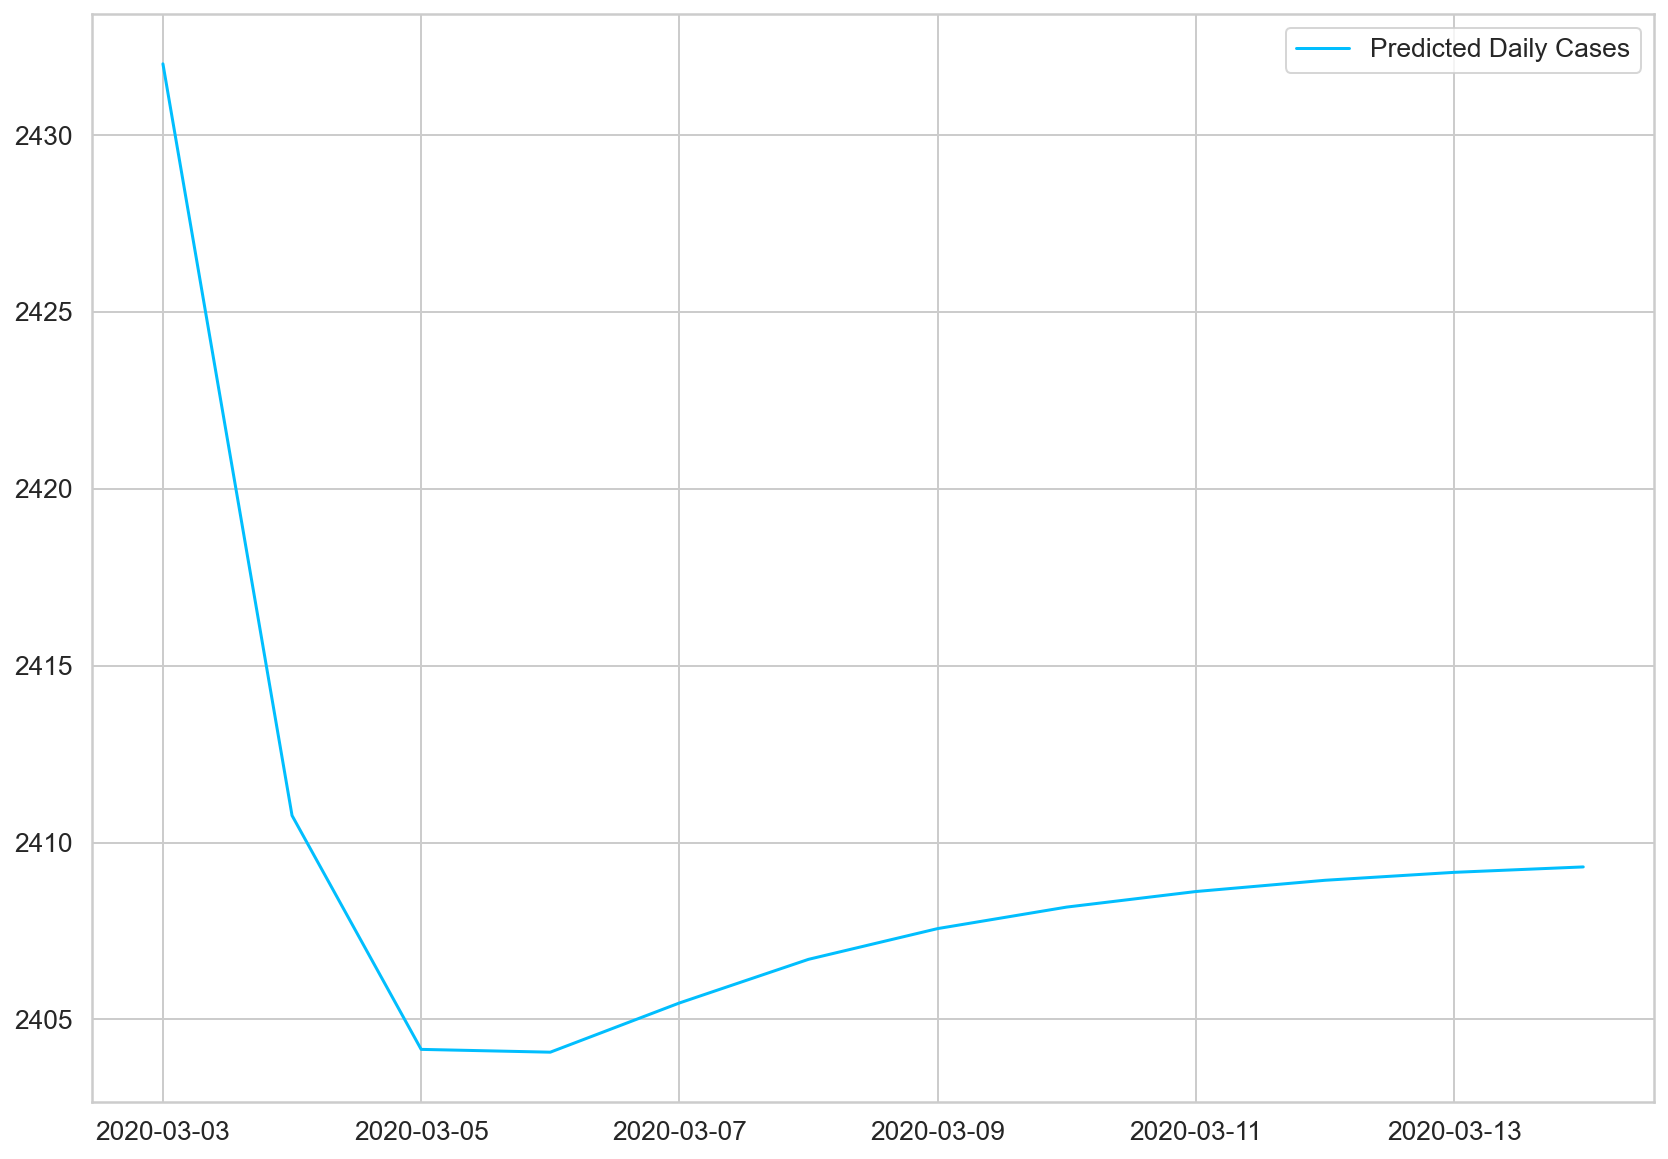

In [53]:
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

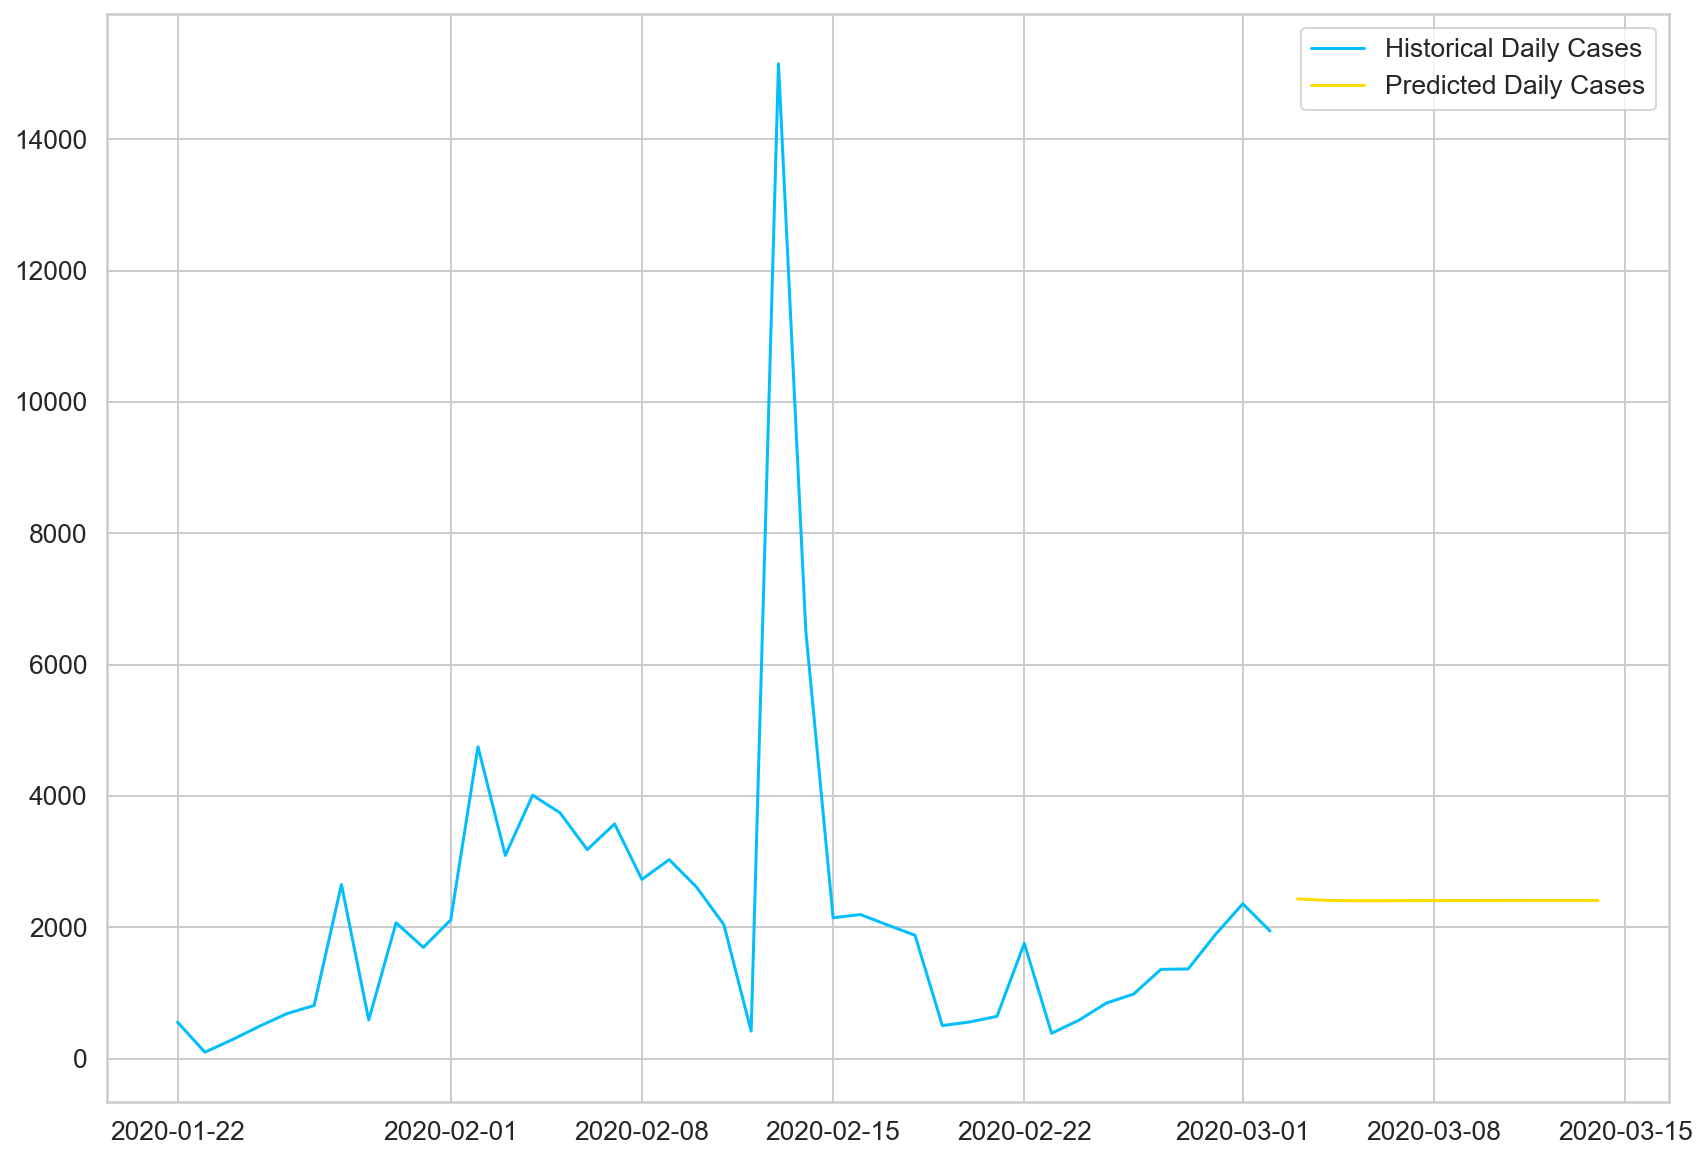

In [54]:
plt.plot(daily_cases, label='Historical Daily Cases')
plt.plot(predicted_cases, label='Predicted Daily Cases')
plt.legend();

In [ ]:
'''
最终的预测结果不是很好。大概率是因为数据量太少了。
'''